           ┌───┐
q_0: ─o──o─┤ Z ├
      │  │ └───┘
q_1: ─o──■──────
      │  │      
q_2: ─■──o──────
      │         
q_3: ─o─────────
                
{   'assignment': '0001',
    'circuit_results': [   {   '0000': 194,
                               '0001': 2,
                               '0010': 3,
                               '0011': 5,
                               '0100': 6,
                               '0101': 5,
                               '0110': 203,
                               '0111': 5,
                               '1000': 172,
                               '1001': 6,
                               '1010': 3,
                               '1011': 3,
                               '1100': 198,
                               '1101': 3,
                               '1110': 211,
                               '1111': 5},
                           {   '0000': 205,
                               '0001': 1,
                               '0010': 3,
          

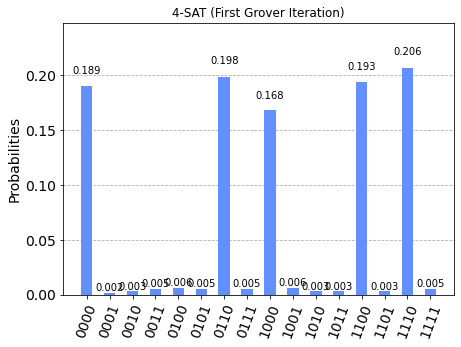

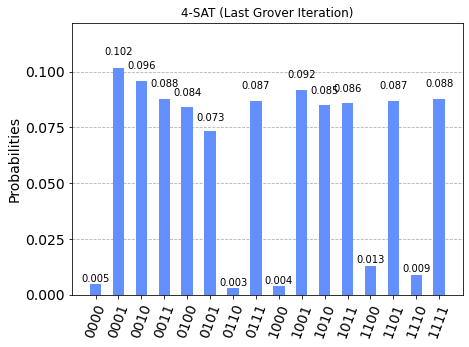

In [8]:
import numpy as np
from qiskit import Aer
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import PhaseOracle
from IPython.display import display

# used 
# 3-SATproblem.dimacs
# 4-SATproblem.dimacs
# 5-SATproblem.dimacs
# test3-SAT.dimacs
# test4-SAT.dimacs

oracle = PhaseOracle.from_dimacs_file('test4-SAT.dimacs')
print(oracle)

v = Verifier('test4-SAT.dimacs')

class Verifier():
    """Create an object that can be used to check whether
    an assignment satisfies a DIMACS file.
        Args:
            dimacs_file (str): path to the DIMACS file
    """
    def __init__(self, dimacs_file):
        with open(dimacs_file, 'r') as f:
            self.dimacs = f.read()

    def is_correct(self, guess):
        """Verifies a SAT solution against this object's
        DIMACS file.
            Args:
                guess (str): Assignment to be verified.
                             Must be string of 1s and 0s.
            Returns:
                bool: True if `guess` satisfies the
                           problem. False otherwise.
        """
        # Convert characters to bools & reverse
        guess = [bool(int(x)) for x in guess][::-1]
        for line in self.dimacs.split('\n'):
            line = line.strip(' 0')
            clause_eval = False
            for literal in line.split(' '):
                if literal in ['p', 'c']:
                    # line is not a clause
                    clause_eval = True
                    break
                if '-' in literal:
                    literal = literal.strip('-')
                    lit_eval = not guess[int(literal)-1]
                else:
                    lit_eval = guess[int(literal)-1]
                clause_eval |= lit_eval
            if clause_eval is False:
                return False
        return True



# Configure backend
backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)

# Create a new problem from the phase oracle and the
# verification function
problem = AmplificationProblem(oracle=oracle, is_good_state=v.is_correct)

# Use Grover's algorithm to solve the problem
grover = Grover(quantum_instance=quantum_instance)
result = grover.amplify(problem)
result.top_measurement

print(result)
# display(plot_histogram(result.circuit_results[0], title= "3-SAT (First Grover Iteration)"))
# display(plot_histogram(result.circuit_results[-1], title= "3-SAT (Last Grover Iteration)"))
display(plot_histogram(result.circuit_results[0], title= "4-SAT (First Grover Iteration)"))
display(plot_histogram(result.circuit_results[-1], title= "4-SAT (Last Grover Iteration)"))
# display(plot_histogram(result.circuit_results[0], title= "5-SAT (First Grover Iteration)"))
# display(plot_histogram(result.circuit_results[-1], title= "5-SAT (Last Grover Iteration)"))

gates =  OrderedDict([('u2', 168), ('cx', 146), ('u3', 53), ('u1', 50), ('measure', 4), ('barrier', 1)])
depth =  252


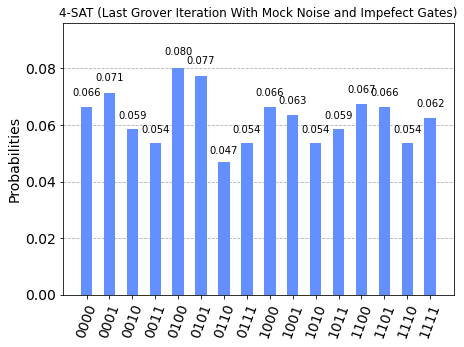

In [9]:
from qiskit.test.mock import FakeMelbourne
melbourne = FakeMelbourne()

from qiskit.compiler import transpile

# transpile the circuit for ibmq_16_melbourne
qc = grover.construct_circuit(problem, max(result.iterations))
qc.measure_all()
grover_compiled = transpile(qc, backend=melbourne, optimization_level=3)

print('gates = ', grover_compiled.count_ops())
print('depth = ', grover_compiled.depth())

from qiskit import assemble
counts = melbourne.run(assemble(grover_compiled)).result().get_counts()
# display(plot_histogram(counts, title = "3-SAT (Last Grover Iteration With Mock Noise and Impefect Gates)"))
display(plot_histogram(counts, title = "4-SAT (Last Grover Iteration With Mock Noise and Impefect Gates)"))